# **TP: Play with CNN**

---
With the following exercises, we will get familiar with Convolutional Neural Networks (CNN), by building an image classifier from making a data loader (a module that gives inputs for the network) to training/testing the classifier. Today's session consists of the following steps:


1.   Setup your coding environment with *Google Colab*, 
2.   Download and pre-process CIFAR10 data using *torchvision*, 
3.   Define a CNN and its loss function,
4.   Train the network on the train set,
5.   Test the trained network with the validation set.
6.   To go further...

In this practicing session, we will use a deep learning framework called *Pytorch* and its computer vision toolbox *torchvision*. This practicing session is largely modified from its official tutorial.

Let's get started and have fun!


# 1. Setup with Colab
*Colab* notebooks offer an easy way to build and run your code online without installing dependencies locally. *Colab* works with *Jupyter Notebook — IPython*. We now set up our *Colab* environment step by step:


1).   go to [Colab](https://colab.research.google.com/notebooks/intro.ipynb?hl=en#scrollTo=GJBs_flRovLc),

2).   sign up with your google account and upload the notebook CNN_TP.ipynb,


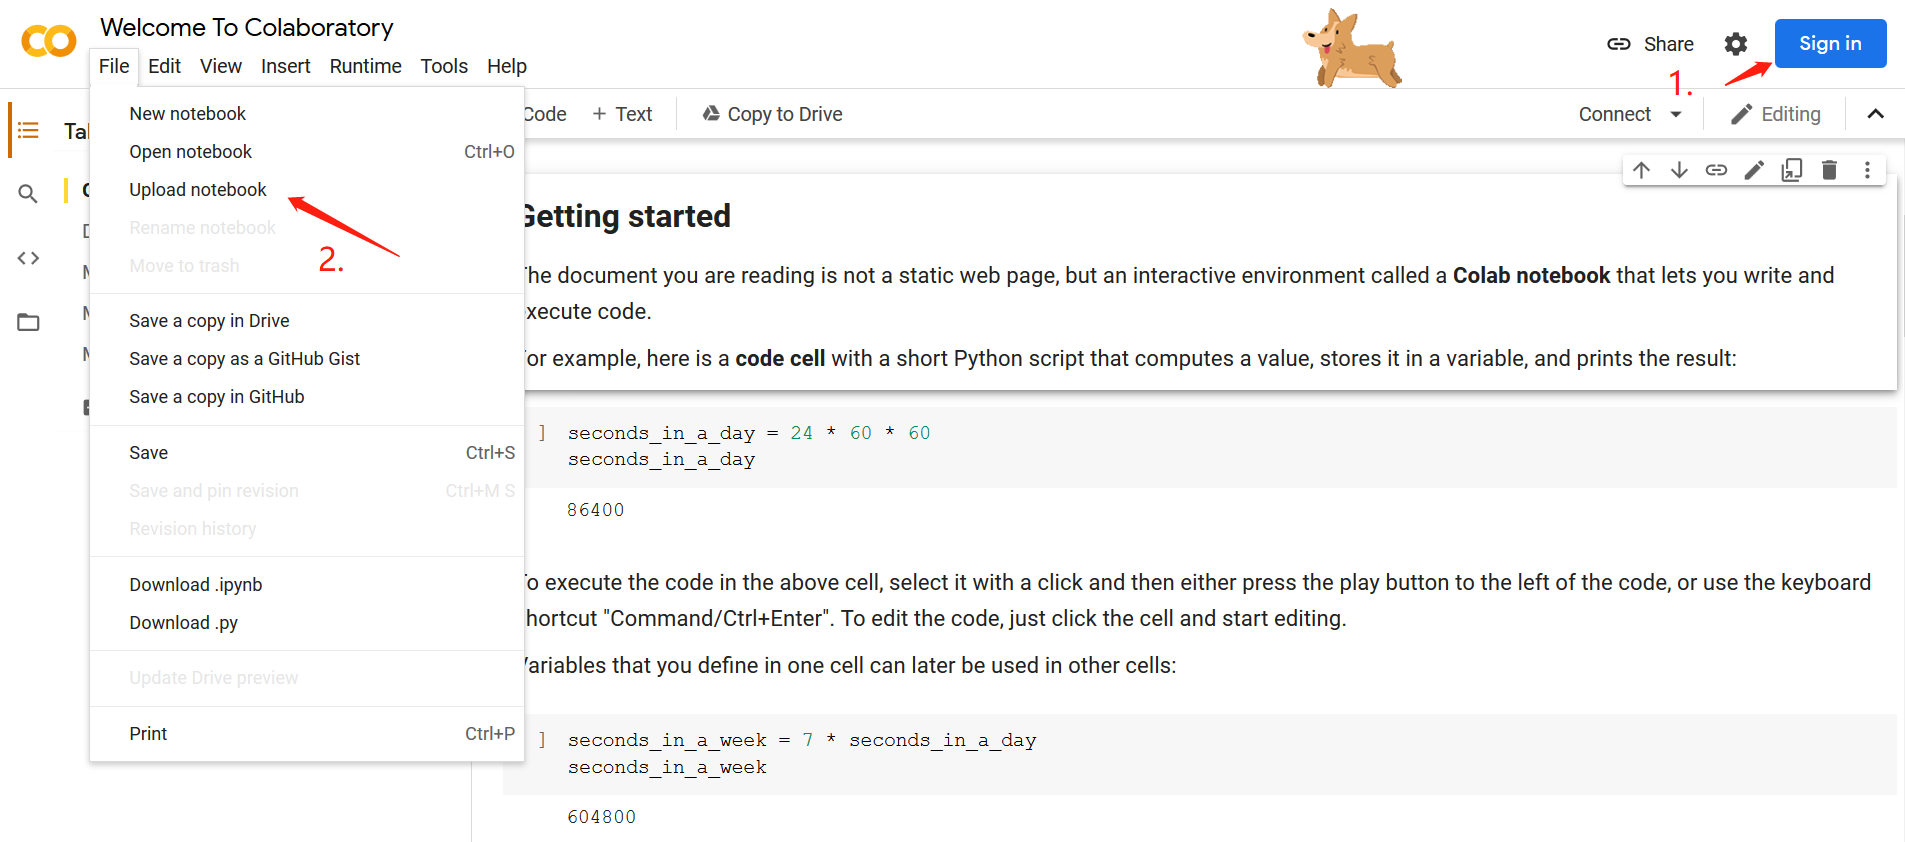




3).   choose to run the code with the hosted runtime.
# 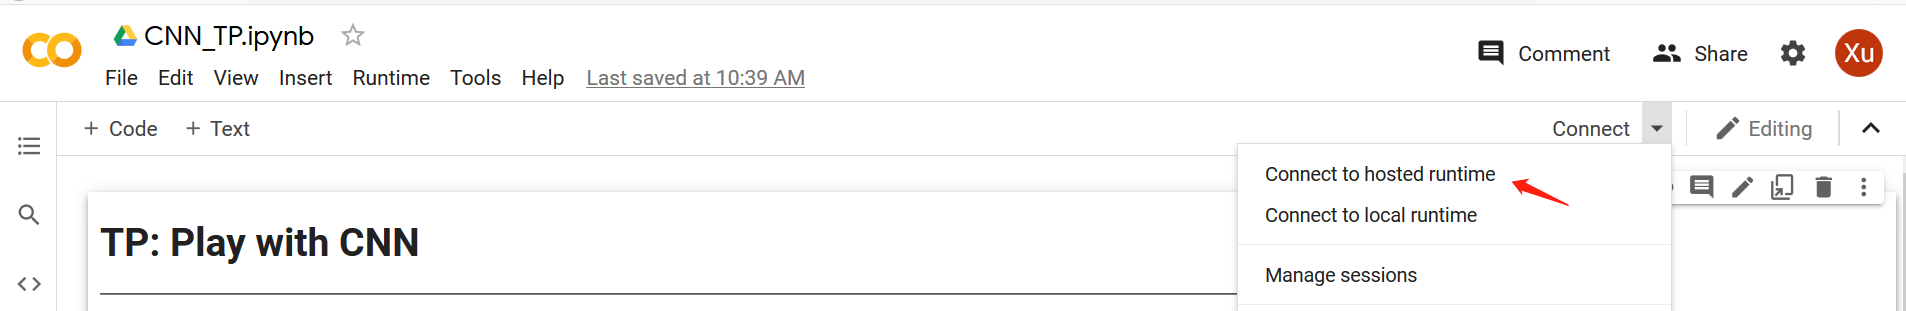



Normally, you can now run your code with *Colab* by clicking on the run button:
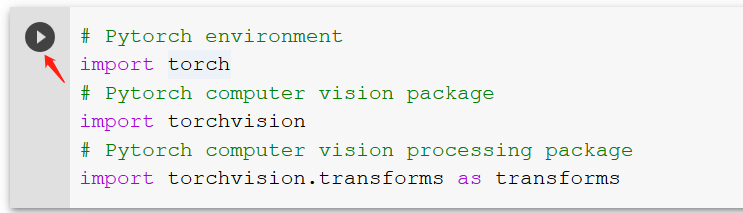

4) upload the pretrained model *cifar_net_epoch200.pth* to Files.

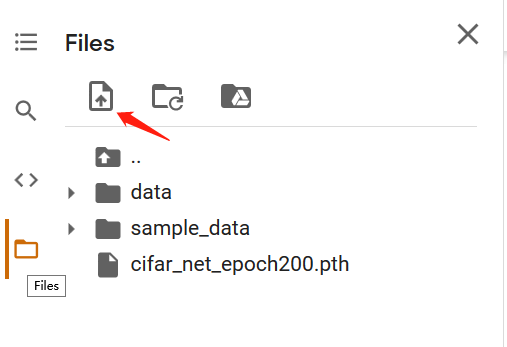


# 2. Download and preprocess CIFAR10 dataset

[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) is a dataset of 60,000 color images with size 3x32x32 (RGB channels X Height X Width). It contains 10 classes:  ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’.

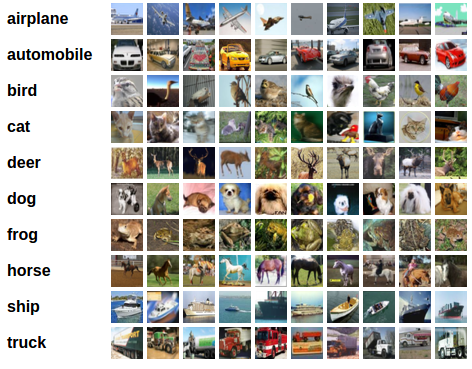


## I.import python packages
 You can easily download CIFAR10 dataset using [*torchvision.dataset*](https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=cifar10#torchvision.datasets.CIFAR10) package, before doing that, let's import some useful packages to the Ipython environment.


In [ ]:
# Pytorch environment
import torch
# Pytorch computer vision package
import torchvision
# Pytorch computer vision processing package
import torchvision.transforms as transforms
# Package for plotting
import matplotlib.pyplot as plt
# Numpy for array computations 
import numpy as np
# Pytorch neural networks moudles library
import torch.nn as nn
# Pytorch optimization modules library
import torch.optim as optim
# Pytorch functions
import torch.nn.functional as F

## II. define pre-porcessing method: transform
In deep learning, we usually normalize the input data within a range for a better convergence during training. Before loading the dataset, we need to tell Pytorch our way of normalization (i.e. transforms). Knowing that the output images of *torchvision.dataset* are of **range [0,1]**. If we want to **normalize it to [-1, 1]**, we can use *[torchvision.transforms.Normalize](https://pytorch.org/docs/stable/torchvision/transforms.html?highlight=torchvision%20transforms%20normalize#torchvision.transforms.Normalize)*. You can complete the following code to define the transform, by replacing 

```
([mean value R],[mean value G], [mean value B])
```

 and
 

```
([std value R],[std value G], [std value B])
```

with the correct values.

Tips: We normalize the RGB channels equally. If you look at the documentation of *torchvision.transforms.Normalize*, you will find that the output after the transform will be:

```
output[channel] = (input[channel] - mean[channel]) / std[channel]
```

In [ ]:
# define the transform
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

## III. download CIFAR10 and load randomly in a batch 
OK, let's get the data with your predefined transform (pre-processing). During training, we usually split the dataset into trainset and validation set. We use transet data to train the network, and we validate our training with a validation set (data that the network has never seen). *torchvision* already does the job for us, you can simply define it by setting the argument *train=True* (trainset) or *train=False* (validation set).

In [ ]:
# define trainset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# # define valset
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

#define classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Getting the data is not enough :( . We need to load the data randomly during training and load multiple images at a time (i.e. training with batches). For these reasons, let's shuffle the trainset and load in by a batch size of 4 (however, we don't need to randomly pick validation set data) using [*torch.utils.DataLoader*](https://pytorch.org/docs/stable/data.html?highlight=torch%20utils%20dataloader#torch.utils.data.DataLoader).

In [ ]:
# put the trainset into DataLoader, with shuffle=True and batch_size=4
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
# put the valset into DataLoader, with shuffle=False and batch_size=4
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

## IV. visualize your data
Ouf, it's done (for data loading)! Let's first visualize them. 

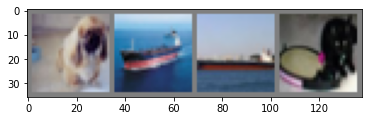

  dog  ship  ship   cat


In [ ]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# 3. Define a CNN and its loss function
## I. write your own (first) neural network
A classic CNN network consists of several convolutional layers, activation functions, pooling operations and finally some fully-connected (Linear) layers. In Pytorch, we define a network as a class heritated from [*torch.nn.Module*](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). Precisely, we define all the modules in the __init__ function of the class such as [*torch.nn.Conv2d*](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html?highlight=torch%20nn%20conv2d#torch.nn.Conv2d), [*torch.nn.Linear*](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=torch%20nn%20linear#torch.nn.Linear), [*torch.nn.MaxPool2d*](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html?highlight=torch%20nn%20maxpool2d#torch.nn.MaxPool2d) and [*torch.nn.ReLU*](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=relu#torch.nn.ReLU).

After initializing all the components, we will define how to run them (the structure of the network) in the ***forward***  function. Please complete the following by reading PyTorch documentations (click on each module). No panic, let's do it step by step!

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #1. define a Conv2d layer named *conv1* of shape
        # [# input channels:3, # output channels:6, kernel size:5x5]
        self.conv1 = nn.Conv2d(3, 6, 5)
        #2. define a Maxpooling2D named *pool*
        # with kernel height=2, and kernel width=2
        self.pool = nn.MaxPool2d(2, 2)
        #3. define a second Conv2d layer named *conv2* of
        # shape [#input channels:6, # output channels:16, kernel size:5x5]
        self.conv2 = nn.Conv2d(6, 16, 5)
        #4. define three fully connected layers named *fc1*, *fc2* and *fc3* where
        #5. fc1 = (input dim= 16*5*5, output dim=120)
        #6. fc2 = (input dim= 120, output dim=84)
        #7. fc3 = (input dim= 84, output dim=?) 
        # what is the value of ?, if we want to classify 10 classes?
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # here define the network with the following structure:
        # x (the input)=> conv1=> relu => pool
        # => conv2=> relu => pool => flatten 
        # (using x.view(batchsize, 16*5*5))
        # => fc1 => relu => fc2=> relu => fc3
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# init an instance of class Net named net
net = Net()

## II. define loss function for classification

Bravo! You managed to build your own network! Let's move forward: define a training loss for classification. A loss function is used for minimizing the errors of your predictions using the gradient descent method by an optimizer. For image classification, a classic loss is [*Cross Entropy loss*](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html?highlight=nn%20crossentropyloss#torch.nn.CrossEntropyLoss):

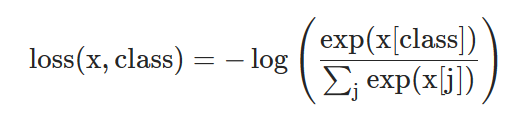

**x** is the predicted logics of shape [batch size, #classes], we can normalize it with a [*softmax* ](https://en.wikipedia.org/wiki/Softmax_function)function (!!warning!! this is already done in the [*nn.CrossEntropyLoss*](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html?highlight=nn%20crossentropyloss#torch.nn.CrossEntropyLoss) in Pytorch.i.e. You don't need to apply the softmax function using *nn.CrossEntropyLoss*) which scales the prediction of each class to [0,1] and make the sum of them to 1 ( An animal cannot be a dog and cat at the same time :) ).

**class** of shape [batch size] is the target class index (starting from 0) of each element in a batch. For example, if we have 4 images in a batch and they are, respectively, [dog, dog, dog, cat], then **class** is of shape [4] and values [5,5,5,3],according the ordering of classes that we pre-defined: classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck').

By minimizing the loss function, we can see from the equation that we are optimizing the probabilities of the target classes.

In [ ]:
# initialize a loss function class called *criterion* using nn.CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

The gradient descent optimization is done by an **optimizer** which updates the network trainable parameters along the negative gradient direction. In Pytorch, all the widely used optimizers in implemented in the module [*torch.optim*](https://pytorch.org/docs/stable/optim.html?highlight=torch%20optim#module-torch.optim). For avoiding tedious parameter tuning procedures (part of deep learning work:) ). We here use [*torch.optim.Adam*](https://pytorch.org/docs/stable/optim.html?highlight=torch%20optim%20adam#torch.optim.Adam).

In [ ]:
# define an Adam optimizer with learning lr=0.001, called *optimizer*
optimizer = optim.Adam(net.parameters(), lr=0.001)

# 3.Train the network on the train set

We are almost there! Look what we've done:

1) We've downloaded CIFAR10 data and put it to a data loader with a batch size of 4,

2)we've defined our classifier using CNN,

3) we've written our loss function and optimizer.

Now the (second-to-) last step: put all the bricks from 1) to 3) together and train your network.

For a CNN network, the training could take several hours to several days(weeks). To speed up, we can finetune a pre-trained model for 5 epochs.

In [ ]:
# load the saved model (from './cifar_net_epoch200.pth')using torch.load (it will load the model weights as dict)
#, and give the model weights to net, using net.load_state_dict()
print("Loading pretrained model...")
net.load_state_dict(torch.load('./cifar_net_epoch200.pth' ,map_location=torch.device('cpu')))

# start training
print("Start training...")
for epoch in range(5):  # Loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients, this operation cleans up the gradients 
        # at the previous iteration.
        optimizer.zero_grad()

        # forward => backward => optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[epoch %d/5, data%5d/12000] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

# never forget to save your trained model.
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)
print('Finished Training')

Loading pretrained model...
Start training...
[epoch 1/5, data 2000/12000] loss: 1.717
[epoch 1/5, data 4000/12000] loss: 1.379
[epoch 1/5, data 6000/12000] loss: 1.305
[epoch 1/5, data 8000/12000] loss: 1.271
[epoch 1/5, data10000/12000] loss: 1.239
[epoch 1/5, data12000/12000] loss: 1.195
[epoch 2/5, data 2000/12000] loss: 1.106
[epoch 2/5, data 4000/12000] loss: 1.108
[epoch 2/5, data 6000/12000] loss: 1.124
[epoch 2/5, data 8000/12000] loss: 1.115
[epoch 2/5, data10000/12000] loss: 1.116
[epoch 2/5, data12000/12000] loss: 1.122
[epoch 3/5, data 2000/12000] loss: 0.989
[epoch 3/5, data 4000/12000] loss: 1.013
[epoch 3/5, data 6000/12000] loss: 1.007
[epoch 3/5, data 8000/12000] loss: 1.002
[epoch 3/5, data10000/12000] loss: 1.045
[epoch 3/5, data12000/12000] loss: 1.040
[epoch 4/5, data 2000/12000] loss: 0.941
[epoch 4/5, data 4000/12000] loss: 0.952
[epoch 4/5, data 6000/12000] loss: 0.964
[epoch 4/5, data 8000/12000] loss: 0.967
[epoch 4/5, data10000/12000] loss: 0.936
[epoch 4/5,

#5. Test the trained network with the validation set.

At this final step, we will play on the validation set and validate the training performance with the metric accuracy.

## I. visualize your validation set


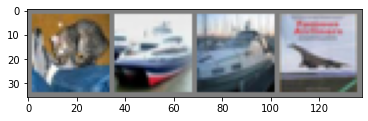

GroundTruth:    cat       ship       ship      plane


In [ ]:
# load one batch from the valloader
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images using the imshow function as defined at 2-IV.
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', '      '.join('%5s' % classes[labels[j]] for j in range(4)))

It looks good the ground-truth labels. What about our trained model?
## II. validate your model on validation set# 


In [ ]:
# initialize a new instance of class Net named net
net = Net()
# load the saved model using torch.load (from './cifar_net.pth', it will load the
# model weights as dict), and give the model weights to net, using net.load_state_dict()
net.load_state_dict(torch.load('./cifar_net.pth'))

<All keys matched successfully>

Let's try to predict the first batch of the valloader. we can call the forward function by directly using net(images). Recall that the outputs are of shape [batchsize, 10=#classes], one probability for each class, respectively. To get the predicted class, we can apply a softmax fucntion, then the 10 outputs can be viewed as probabilities. We chose the class with maximum probability.

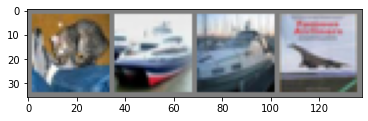

Predicted:  cat,p=0.45    ship,p=0.96    ship,p=0.85    plane,p=1.00   
GroundTruth:    cat   ship   ship  plane


In [ ]:
# load one batch from the valloader
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images using the imshow function as defined at 2-IV.
imshow(torchvision.utils.make_grid(images))
with torch.no_grad():
  # predict the class for each image using our trained model. 
  outputs = net(images)
  # apply softmax
  outputs = F.softmax(outputs, dim=-1)
  # print(outputs)
  probabilities, predicted = torch.max(outputs, 1)

  print('Predicted: ', ' '.join('{:s},p={:.2f}   '.format(classes[predicted[j]],probabilities[j])
                                for j in range(4)))
  print('GroundTruth: ', '  '.join('%5s' % classes[labels[j]] for j in range(4)))


Knowing that without training, you can only get the right prediction with a chance of 1/10, the result is not bad at all!
Ok, let's calm down. We can now quantitatively evaluate the performance on the validation set by calculating the accuracy.

In [ ]:
# count the # correct predictions, i.e. predicted==labels
correct = 0
# count the total #labels
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # predict the class for each image using our trained model. 
        outputs = net(images)
        # apply softmax
        outputs = F.softmax(outputs, dim=-1)
        probabilities, predicted = torch.max(outputs.data, 1)
        # collect the # of labels using labels.size(0)
        total += labels.size(0)
        # collect the # of correct predictions i.e. predicted==labels
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 63 %


To go further, which classes predict better? Let's print the accuracy by class.

In [ ]:
# save total #predictions for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

# print the acuracies for 10 classes.
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))


Accuracy of plane : 67 %
Accuracy of   car : 68 %
Accuracy of  bird : 42 %
Accuracy of   cat : 33 %
Accuracy of  deer : 62 %
Accuracy of   dog : 54 %
Accuracy of  frog : 75 %
Accuracy of horse : 68 %
Accuracy of  ship : 77 %
Accuracy of truck : 78 %


#6. To go further...

If you are curious enough, you can find that the training is relatively slow. The reason for this, it's that we are using the free version of *Colab* (joking). Seriously, we were training the network using CPUs and with a small batch size of 4! However, in real-world applications, we usually train a CNN with GPU(s) and with a bigger batch size (yes, GPUs are not only for gaming...).
To do so, you can add *.cuda()* to *net*, *labels*, *images*:


```
...
net = Net()
net = net.cuda()
...
images, labels = data
images = images.cuda()
labels = labels.cuda()
...
```

This will send the network and data to the GPU and run them on it, which is much faster (you need to pay Colab, though :).

Further more, if you are not happy with the performance of our model, you can go try some well-known models such as *VGG-16*, *ResNet-50*, *ResNet-101*, etc. These models can be obtained also from [*torchvision.models*](https://pytorch.org/docs/stable/torchvision/models.html)

The following link can help you learn more about deep learning and practice with tutorials in Pytorch. Have fun and welcome to the CNN world!

[Pytorch Tutorials](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)